# Mujoco Control 
This tutorial introduces how to set up closed-loop control system for multi-body robotic systems in Mujoco. 


In [10]:
import mujoco
import mediapy as media
import numpy as np

import mujoco.viewer as viewer
modelxml = """
<mujoco model="CartPole">
  <compiler eulerseq="XYZ"/>
  <default>
    <default class="unused"/>
  </default>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1="0.1 0.2 0.3" rgb2="0.2 0.3 0.4" width="512" height="512"/>
    <material name="grid" class="unused" texture="grid" texrepeat="1 1" texuniform="true" reflectance="0.2"/>
  </asset>
  <worldbody>
    <geom name="floor" class="unused" type="plane" condim="3" size="0 0 0.05" material="grid" pos="0 0 -1"/>
    <body name="Cart" pos="0 0 0" euler="0 -0 0">
    <!-- change inertia, different from sdf -->
    <!-- For this model case, with the cart not having any rotational
             degrees of freedom, the values of the inertia matrix do not
             participate in the model. Therefore we just set them to zero
             (or near to zero since sdformat does not allow exact zeroes
             for inertia values). -->
      <inertial pos="0 0 0" mass="5" diaginertia="0.00000000001 0.00000000001 0.00000000001"/>
      <geom name="cart_visual" class="unused" type="box" contype="0" conaffinity="0" group="0" size="0.12 0.06 0.06" pos="0 0 0" euler="0 -0 0"/>
      <joint name="CartSlider" class="unused" type="slide" pos="0 0 0" axis="1 0 0"/>
      <body name="Pole" pos="0 0 -0.5" euler="0 -0 0">
        <inertial pos="0 0 0" mass="1" diaginertia="0.00000000001 0.00000000001 0.00000000001"/>
        <geom name="pole_rod" class="unused" type="cylinder" contype="0" conaffinity="0" group="0" size="0.025 0.25" pos="0 0 0.25" euler="0 -0 0"/>
        <geom name="pole_point_mass" class="unused" type="sphere" contype="0" conaffinity="0" group="0" size="0.05" pos="0 0 0" euler="0 -0 0"/>
        <joint name="PolePin" class="unused" type="hinge" pos="0 0 0.5" axis="0 -1 0"/>
      </body>
    </body>
  </worldbody>
  <sensor>
        <!-- joint position sensing -->
        <jointpos joint="CartSlider" name="cart_p"/>
        <jointpos joint="PolePin" name="pole_theta"/>
        <!-- joint velocity sensing -->
        <jointvel joint="CartSlider" name="cart_v"/>
        <jointvel joint="PolePin" name="pole_w"/>
  </sensor>
  <actuator>
    <motor joint="CartSlider"/>
  </actuator>
  <keyframe>
    <key name="off1" qpos="0 3.15"/>
  </keyframe>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(modelxml)
data = mujoco.MjData(model)
mujoco.mj_resetDataKeyframe(model, data, 0)
viewer.launch(model,data)

### Simulatioin of open-loop resposne 
now let's simulate the physics


""

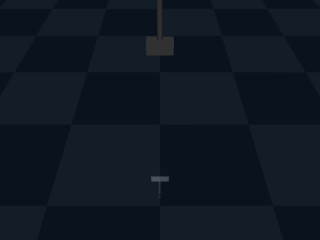

In [2]:
duration = 3    # (seconds)
framerate = 30  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data)
      pixels = renderer.render()
      frames.append(pixels)
media.show_video(frames, fps=framerate, codec='gif')

In [ ]:
# define customized controller which returns the feedback control action
# if we want to use control callback, we need to set data.ctrl, the returned value does not matter in this case
def myControl(model, data):
    x = np.hstack((data.qpos,data.qvel))
    xref = np.array([0, np.pi, 0, 0])
    x_error = x-xref
    K = np.array([0.5, 0.5, 0, 0])
    u = K@x_error
    data.ctrl = u
    return u

In [21]:
import mujoco.viewer as viewer
import time

mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0

with viewer.launch_passive(model, data) as viewer:  
  # launch_passive means all the simulation should be done by the user 
  
  start = time.time()
  while viewer.is_running() and time.time() - start < 10:
    step_start = time.time()
    data.ctrl = 0.2*myControl(model,data)
    mujoco.mj_step(model, data)

  # let viewer show updated info
    viewer.sync()
    
    # make sure the while loop is called every sampling period 
    # computation inside the loop may take some nontrivial time. 
    time_until_next_step = model.opt.timestep - (time.time() - step_start)
    if time_until_next_step > 0:
      time.sleep(time_until_next_step)

### Simulation method 1: 
interactive simulation, the viewer can respond to user's input during the simulation

In [30]:
# simulating the closed-loop system by using the control callback

import mujoco.viewer as viewer
mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0
mujoco.set_mjcb_control(myControl)
viewer.launch(model,data)

### Simuation method 2:
Passive simulation, the user has the control over stepping the physics 

In [37]:
import mujoco.viewer as viewer
import time

mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0
with viewer.launch_passive(model,data) as viewer:
    while viewer.is_running() and data.time < 20:
        data.ctrl = 20*myControl(model,data)  # apply control
        mujoco.mj_step(model, data)            # step xdot= f(x,u)
        viewer.sync()
        time.sleep(model.opt.timestep)        


[0.   3.15 0.   0.  ]
[6.59768128e-08 3.15000079e+00 3.29884064e-05 3.95874868e-04]
[1.97936914e-07 3.15000238e+00 6.59800508e-05 7.91787278e-04]
[3.95893256e-07 3.15000475e+00 9.89781711e-05 1.18777478e-03]
[6.59865268e-07 3.15000792e+00 1.31986006e-04 1.58387491e-03]
[9.89878858e-07 3.15001188e+00 1.65006795e-04 1.98012526e-03]
[1.38596641e-06 3.15001663e+00 1.98043778e-04 2.37656338e-03]
[1.84816681e-06 3.15002218e+00 2.31100199e-04 2.77322688e-03]
[2.37652541e-06 3.15002852e+00 2.64179301e-04 3.17015337e-03]
[2.97109408e-06 3.15003565e+00 2.97284331e-04 3.56738050e-03]
[3.63193115e-06 3.15004358e+00 3.30418536e-04 3.96494593e-03]
[4.35910149e-06 3.15005231e+00 3.63585169e-04 4.36288736e-03]
[5.15267646e-06 3.15006183e+00 3.96787485e-04 4.76124254e-03]
[6.01273394e-06 3.15007215e+00 4.30028741e-04 5.16004925e-03]
[6.93935834e-06 3.15008327e+00 4.63312198e-04 5.55934529e-03]
[7.93264058e-06 3.15009519e+00 4.96641124e-04 5.95916854e-03]
[8.99267816e-06 3.15010791e+00 5.30018786e-04 6.